In [30]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.interface import spice
from tudatpy.kernel import constants
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup

from datetime import datetime

spice.load_standard_kernels()

from my_functions import state_eci_to_radec, measurement_model, getGammaMatrix, sat_prop_time_efficient, kl_divergence, compute_elevation, compute_solar_phase_angle



In [31]:
# BASIC SETTINGS
# Target sats initial state
targets = ["Sat1","Sat2","Sat3"]
# targets = ["Sat1"]
sat_name_to_index = {'Sat1': 1, 'Sat2': 2, 'Sat3': 3}
# sat_name_to_index = {'Sat1': 1}
initial_state_targets = dict()

# Block to create initial state from keplerian state
mu_earth = 398600.4418e9
sat_kep_1 = np.array([10738e3,0.0002,np.deg2rad(70),np.deg2rad(250),0,np.deg2rad(30)])
sat_kep_2 = np.array([20780e3,0.001,np.deg2rad(60),np.deg2rad(350),0,np.deg2rad(30)])
sat_kep_3 = np.array([26562e3,0.01,np.deg2rad(55),np.deg2rad(300),0,np.deg2rad(30)])
initial_state_targets[targets[0]] = element_conversion.keplerian_to_cartesian(sat_kep_1,mu_earth)
initial_state_targets[targets[1]] = element_conversion.keplerian_to_cartesian(sat_kep_2,mu_earth)
initial_state_targets[targets[2]] = element_conversion.keplerian_to_cartesian(sat_kep_3,mu_earth)

# [-6.48376670e+06, -1.21721233e+06,  1.37436724e+06, -3.07495709e+02, -4.97867720e+03, -5.85350139e+03]
# [-6.12665835e+06,  4.92286968e+05, -3.50280379e+06,  3.74842925e+03,  9.05386134e+02, -6.44215709e+03]
# [-2.30010664e+07, -7.61690688e+06, -1.08780704e+07,  1.97055255e+03, -1.91323133e+03, -2.73237751e+03]

# Ground station
station_name ='REY30' 
geodetic_position = {'REY30': [3058.789875087734,20.709152020592995, -156.2600015424928]}

gs_alt_m = geodetic_position[station_name][0]
gs_lat_deg = geodetic_position[station_name][1]
gs_lon_deg = geodetic_position[station_name][2]

gs_settings = []
gs_settings.append(environment_setup.ground_station.basic_station(
    station_name,[gs_alt_m,np.deg2rad(gs_lat_deg),np.deg2rad(gs_lon_deg)],element_conversion.geodetic_position_type))

# gs_ecef = [-5466071, -2403990,  2242473]   # In meters
gs_ecef = [-4469000, 2658000,  3650000]   # In meters
gs_eci = {}

# Reference frames
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Time control
time_format = '%Y-%m-%d %H:%M:%S'
start_epoch_string = "2000-01-01 14:00:00"
end_epoch_string = "2000-01-01 20:00:00"
time_step_seconds = 60
jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch_string, time_format))
jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch_string, time_format))
time_buffer = 0
utc_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - time_buffer)
utc_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + time_buffer)
sim_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - time_buffer)
sim_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + time_buffer)
# sim_seconds_start_epoch = 0.0
# sim_seconds_end_epoch = 14400.0

time_vector = np.arange(sim_seconds_start_epoch,sim_seconds_end_epoch + time_step_seconds, time_step_seconds)

In [32]:
# THIS BLOCK CREATES A VECTOR WITH THE GROUND STATION IN ECI 
# Ground station ECI coordinates
bodies_to_create = ["Earth"]
central_bodies = ["Earth"]

# Creating Earth settings
body_settings = environment_setup.get_default_body_settings_time_limited(bodies_to_create, sim_seconds_start_epoch, sim_seconds_end_epoch, global_frame_origin, global_frame_orientation)
for target in targets:
    body_settings.add_empty_settings(target)

# Add Earth Shape settings
eq_rad = 6378*1e3 # in meters
flat = 1/298
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(equatorial_radius = eq_rad,flattening = flat,)

# Add Earth Rotation model
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60))

body_settings.get('Earth').ground_station_settings = gs_settings

bodies = environment_setup.create_system_of_bodies(body_settings)

earth_rotation_model = bodies.get('Earth').rotation_model

times_utc = []    # To store the time vector in UTC

for t in time_vector:
    # get rotation matrix
    R_fixed_to_inertial = earth_rotation_model.body_fixed_to_inertial_rotation(t)
    # get ECI position
    gs_eci[t] = R_fixed_to_inertial @ gs_ecef    # In meters

    time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(t)
    time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
    times_utc.append(time_change_utc)


In [33]:
# THIS BLOCK DEFINES THE ACCELERATION SETTINGS AND CREATES BODIES FOR SATELLITE PROPAGATION
# 2 body Force model settings
bodies_to_create_2b = ['Earth','Sun']
body_settings_2b = environment_setup.get_default_body_settings(bodies_to_create_2b, 'Earth', 'J2000')
body_settings_2b.add_empty_settings("current_sat")

bodies_2b = environment_setup.create_system_of_bodies(body_settings_2b)

bodies_2b.get("current_sat").mass = 10  # arbitrary nonzero mass
acceleration_settings_2b = {
"current_sat": {
    "Earth": [propagation_setup.acceleration.point_mass_gravity()]
}}

acceleration_models_2b = propagation_setup.create_acceleration_models(
    bodies_2b, acceleration_settings_2b,["current_sat"], central_bodies
)


# Full force model settings    
bodies_to_create_ff = ['Sun','Earth','Moon']
body_settings_ff = environment_setup.get_default_body_settings(bodies_to_create_ff,'Earth','J2000')
body_settings_ff.add_empty_settings("current_sat")

# CREATE ACCELERATION SETTINGS
# Aerodynamic drag
ref_area = np.pi * 0.5**2
drag_coef = 2.0
aero_coef_settings = environment_setup.aerodynamic_coefficients.constant(ref_area,[drag_coef,0.0,0.0])

# Solar radiation pressure
rad_coef = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    ref_area, rad_coef, occulting_bodies_dict)

body_settings_ff.get("current_sat").aerodynamic_coefficient_settings = aero_coef_settings
body_settings_ff.get("current_sat").radiation_pressure_target_settings = vehicle_target_settings

bodies_ff = environment_setup.create_system_of_bodies(body_settings_ff)
bodies_ff.get("current_sat").mass = 10

accelerations_settings_target_ff = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
)

# Create global accelerations settings dictionary.
acceleration_settings_ff = {"current_sat": accelerations_settings_target_ff}

# Create acceleration models.
acceleration_models_ff = propagation_setup.create_acceleration_models(
    bodies_ff,
    acceleration_settings_ff,
    ["current_sat"],
    central_bodies)


# Integrator & propagation
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
    time_step_seconds, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
)

In [34]:
# EKF & SENSOR TASKING

# Noise matrices
q_pos = 1e-15    # km^2
Q = np.eye(3) * q_pos  # km^2
R = np.diag([1e-10 * 0.235043863818291, 1e-10 * 0.235043863818291])   # rad^2
R_std = np.sqrt(R[0][0])

converged = 1

est_state = {target: dict() for target in targets}
true_state = {target: dict() for target in targets}
est_cov   = {target: dict() for target in targets}
est_ra    = {target: dict() for target in targets}  # will store in radians
est_dec    = {target: dict() for target in targets}
true_ra_deg    = {target: dict() for target in targets}
true_dec_deg    = {target: dict() for target in targets}
resids    = {target: dict() for target in targets}

Xref_Stm0 = {}
x_true = {}
Xref_k = {}
xhat_k = {}
xhat_k_kminus1 = {}
resids_temp = {}
P_est_dict = {}


for target in targets:
    Xref_Stm0[target] = {}
    x_true[target] = initial_state_targets[target] / 1000  # km
    P_est_dict[target] = np.diag([1e2,1e2,1e2,1e-4,1e-4,1e-4])
    # Xref_Stm0[target]["Xref"] = x_true[target] + np.random.multivariate_normal(mean = np.zeros(6), cov = P_est_dict[target])
    Xref_Stm0[target]["Xref"] = x_true[target]             # km
    # Xref_Stm0[target]["Xref"] = x_true[target] + np.array([1,1,1,0.01,0.01,0.01])
    Xref_Stm0[target]["Phi0"] = np.eye(6)                  # unitless

xhat_k_prev_dict = {target: np.zeros(6) for target in targets}
# P_est_dict = {target: np.diag([1e2,1e2,1e2,1e-4,1e-4,1e-4]) for target in targets}
Xref_prev_dict = {target: Xref_Stm0[target]["Xref"] for target in targets}
t_pre_dict = {target: time_vector[0] for target in targets}

station_id = ('Earth', station_name)
best_target = {}
best_target_num_log = {}

np.random.seed(31)

for idx, tk in enumerate(time_vector):
    
    preds = {}
    posts = {}
    kl_candidates = {}

    for target in targets:
        t_pre = t_pre_dict[target]
        xhat_k_prev = xhat_k_prev_dict[target]
        P_est = P_est_dict[target]
        Xref_prev = Xref_prev_dict[target]

        Gammak = getGammaMatrix(t_pre, tk)
        
        # True propagation
        if idx == 0:
            x_true[target] = Xref_Stm0[target]["Xref"]
        else:
            # Two body
            prop_temp,_ = sat_prop_time_efficient(x_true[target]*1000,t_pre,tk,acceleration_models_2b,integrator_settings,bodies_2b)
            # Full force model
            # prop_temp,_ = sat_prop_time_efficient(x_true[target]*1000,t_pre,tk,acceleration_models_ff,integrator_settings,bodies_ff)
            
            x_true[target] = list(prop_temp.values())[-1].flatten() / 1000

        true_state[target][idx] = x_true[target]

        temp_true_ra_rad, temp_true_dec_rad = state_eci_to_radec(x_true[target], gs_eci[tk]/1000)

        true_ra_deg[target][idx] = np.rad2deg(temp_true_ra_rad) % 360
        true_dec_deg[target][idx] = np.rad2deg(temp_true_dec_rad)

        # Observation
        zk = np.array([temp_true_ra_rad, temp_true_dec_rad]) + np.random.normal(0, R_std, size=2)
        # zk = np.array([temp_true_ra_rad,temp_true_dec_rad]) + np.random.multivariate_normal(mean = np.zeros(2), cov = R)
        
        # Prediction
        if idx == 0:
            Xref_k[target] = Xref_Stm0[target]["Xref"]
            Phi_k = Xref_Stm0[target]["Phi0"]
        else:
            # Two body
            temp_state, stm_k = sat_prop_time_efficient(Xref_prev*1000,t_pre,tk,acceleration_models_2b,integrator_settings,bodies_2b)
            # Full force model
            # temp_state, stm_k = sat_prop_time_efficient(Xref_prev*1000,t_pre,tk,acceleration_models_ff,integrator_settings,bodies_ff)
            
            Xref_k[target] = list(temp_state.values())[-1].flatten() / 1000
            Phi_k = list(stm_k.values())[-1]

        
        xhat_k_kminus1[target] = Phi_k @ xhat_k_prev
        P_k_kminus1 = Phi_k @ P_est @ Phi_k.T + Gammak @ Q @ Gammak.T

        # EKF update
        gk, H_matrix = measurement_model(Xref_k[target], gs_eci[tk]/1000)
        yk = zk - gk

        S_cov = H_matrix @ P_k_kminus1 @ H_matrix.T + R
        Kk = P_k_kminus1 @ H_matrix.T @ np.linalg.inv(S_cov)
        
        xhat_k[target] = xhat_k_kminus1[target] + Kk @ (yk - H_matrix @ xhat_k_kminus1[target])
        P_est = (np.eye(6) - Kk @ H_matrix) @ P_k_kminus1 @ (np.eye(6) - Kk @ H_matrix).T + Kk @ R @ Kk.T
        x_est = Xref_k[target] + xhat_k[target]

        preds[target] = (xhat_k_kminus1[target] + Xref_k[target], P_k_kminus1)
        posts[target] = (x_est, P_est)

        resids_temp[target] = yk - H_matrix @ xhat_k[target]

        # Calculating solar phase angle
        sun_eci = bodies_ff.get('Sun').ephemeris.cartesian_state(tk)[0:3]  # m
        temp_sat_pos_eci = preds[target][0][0:3]
        solar_phase_angle_rad = compute_solar_phase_angle(temp_sat_pos_eci,sun_eci/1000,gs_eci[tk]/1000)
        solar_phase_angle_deg = np.rad2deg(solar_phase_angle_rad)

        # Calculating elevation
        elevation_anle_rad = compute_elevation(temp_sat_pos_eci,gs_eci[tk]/1000)
        # print(np.rad2deg(elevation_anle_rad))

        # KL divergence
        kl = kl_divergence(P_k_kminus1,P_est)
        # kl_candidates[target] = kl


        if elevation_anle_rad < np.pi/12:
            kl_candidates[target] = 0
        else:
            kl_candidates[target] = kl

    # Choose best target to observe
    best_target = max(kl_candidates, key=kl_candidates.get)
    if kl_candidates[best_target] == 0:   # No valid observation
        best_target_num_log[idx] = 0  
        best_target = "No targets visible"
    else:
        best_target_num_log[idx] = sat_name_to_index[best_target]

    for target in targets:
        if target != best_target:
            est_state[target][idx] = preds[target][0]
            est_cov[target][idx] = preds[target][1]
            ra_post,dec_post = state_eci_to_radec(est_state[target][idx],gs_eci[tk]/1000)
            est_ra[target][idx] = (np.rad2deg(ra_post) % 360)
            est_dec[target][idx] = (np.rad2deg(dec_post))
            resids[target][idx] = np.full((2,), np.nan)

            
            if np.linalg.norm(xhat_k_kminus1[target]) > converged:
                Xref_k[target] = est_state[target][idx]
                xhat_k_kminus1[target] = np.zeros(6)

            Xref_prev_dict[target] = Xref_k[target]
            xhat_k_prev_dict[target] = xhat_k_kminus1[target]
            t_pre_dict[target] = tk
            P_est_dict[target] = est_cov[target][idx]
        else:
            est_state[target][idx] = posts[target][0]
            est_cov[target][idx] = posts[target][1]
            ra_post,dec_post = state_eci_to_radec(est_state[target][idx],gs_eci[tk]/1000)
            est_ra[target][idx] = (np.rad2deg(ra_post) % 360)
            est_dec[target][idx] = (np.rad2deg(dec_post))
            resids[target][idx] = resids_temp[target]

            if np.linalg.norm(xhat_k[target]) > converged:
                Xref_k[target] = est_state[target][idx]
                xhat_k[target] = np.zeros(6)

            Xref_prev_dict[target] = Xref_k[target]
            xhat_k_prev_dict[target] = xhat_k[target]
            t_pre_dict[target] = tk
            P_est_dict[target] = est_cov[target][idx]


# # Plotting
# for target in targets:
#     plt.figure(figsize=(6, 3))
#     plt.scatter(times_utc, est_ra[target].values(), marker='x', s=3, label='Est Right Ascension')
#     plt.scatter(times_utc, est_dec[target].values(), marker='x', s=3, label='Est Declination')
#     plt.scatter(times_utc, true_ra_deg[target].values(), marker='+', s=3, label='True Right Ascension')
#     plt.scatter(times_utc, true_dec_deg[target].values(), marker='+', s=3, label='True Declination')
#     plt.title('Observation of ' + target)
#     plt.xlabel('Time in UTC')
#     plt.ylabel('Degrees')
#     plt.grid(True)
#     plt.legend(prop={'size': 6})
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

        

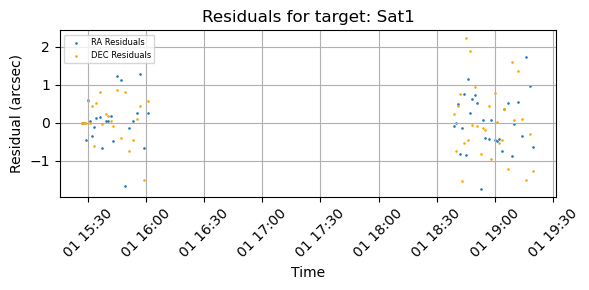

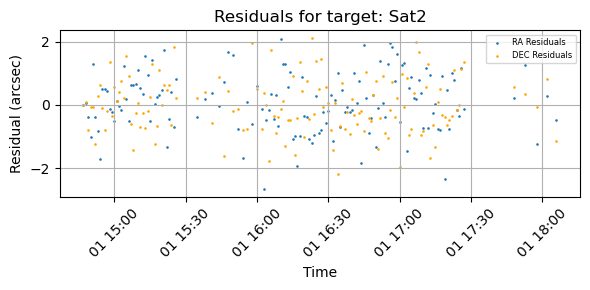

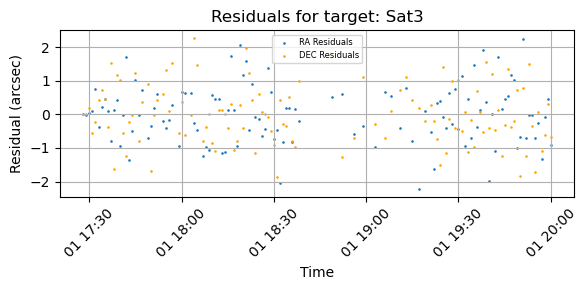

In [35]:
for target in targets:

    idxs = sorted(resids[target].keys())

    residual_array = np.array([resids[target][i] for i in idxs])  # shape (N, 2)

    # Split into RA and DEC residuals
    ra_residuals = residual_array[:, 0] * 3600
    dec_residuals = residual_array[:, 1] * 3600


    plt.figure(figsize=(6, 3))

    plt.scatter(times_utc, np.rad2deg(ra_residuals),marker='.',s=3, label="RA Residuals")
    plt.scatter(times_utc, np.rad2deg(dec_residuals),marker='.',s=3, label="DEC Residuals", color='orange')
    plt.ylabel("Residual (arcsec)")
    plt.xlabel("Time")
    # plt.ylim([-5, 5])
    plt.grid(True)
    plt.legend(prop={'size': 6})
    plt.title(f"Residuals for target: {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



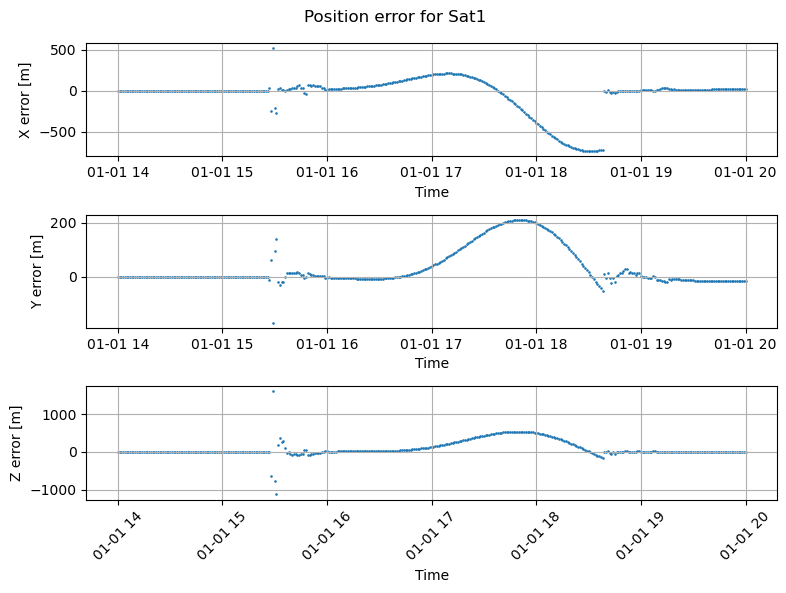

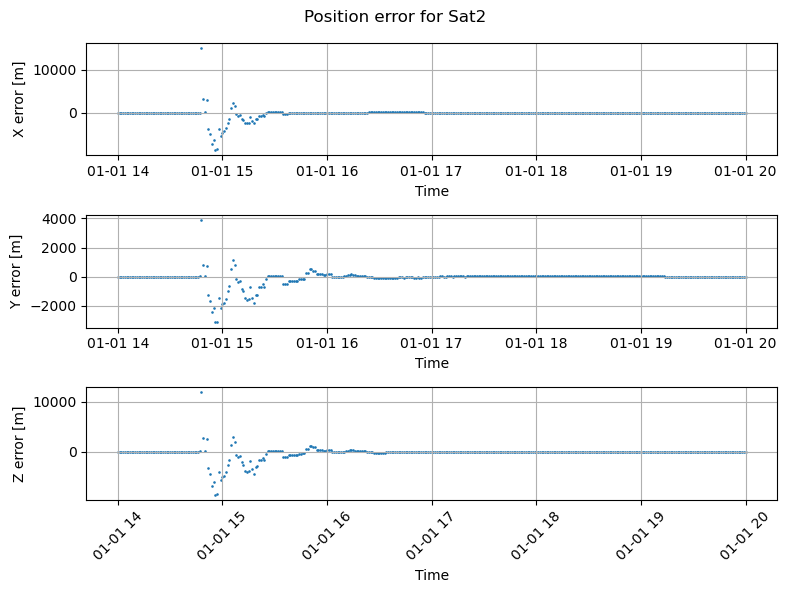

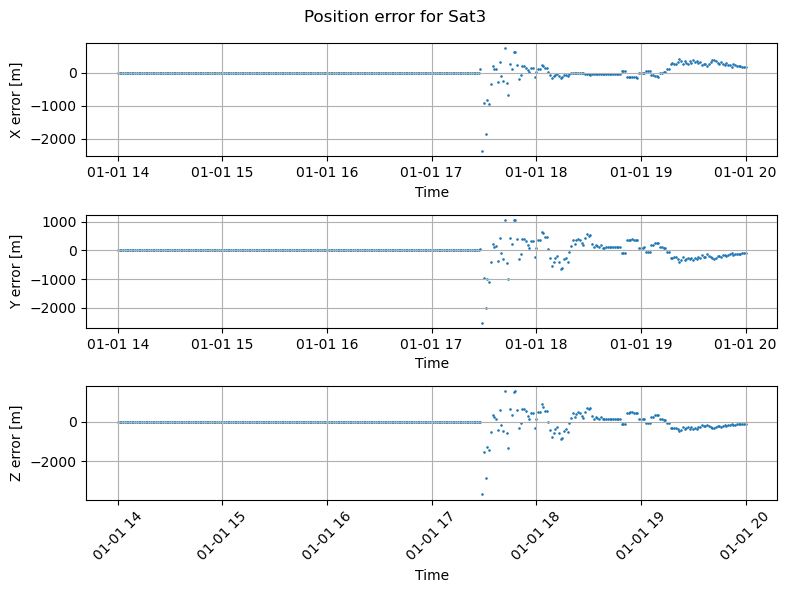

In [36]:
for target in targets:
    true_state_array = np.array([true_state[target][i] for i in idxs]) 
    est_state_array = np.array([est_state[target][i] for i in idxs])  

    er_state = (true_state_array - est_state_array) * 1000
    x_err = er_state[:,0]
    y_err = er_state[:,1]
    z_err = er_state[:,2]


    plt.figure(figsize=(8, 6))

    plt.subplot(3, 1, 1)
    plt.scatter(times_utc, (x_err),marker='.',s=3, label="X error")
    plt.ylabel("X error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    # plt.ylim([-.2, .2])

    plt.subplot(3, 1, 2)
    plt.scatter(times_utc, (y_err),marker='.',s=3, label="Y error")
    plt.ylabel("Y error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    # plt.ylim([-.2, .2])

    plt.subplot(3, 1, 3)
    plt.scatter(times_utc, (z_err),marker='.',s=3, label="Z error")
    plt.ylabel("Z error [m]")
    plt.xlabel("Time")
    plt.grid(True)
    # plt.ylim([-.2, .2])

    plt.suptitle(f"Position error for {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

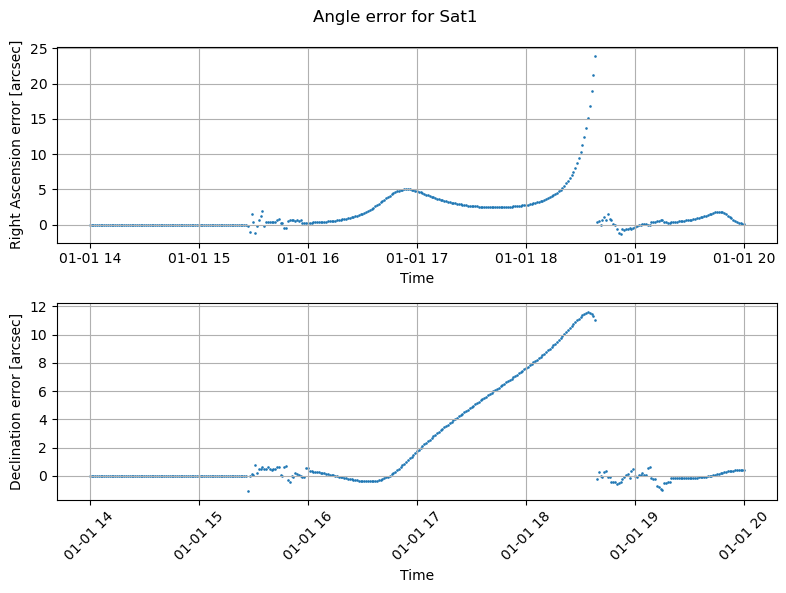

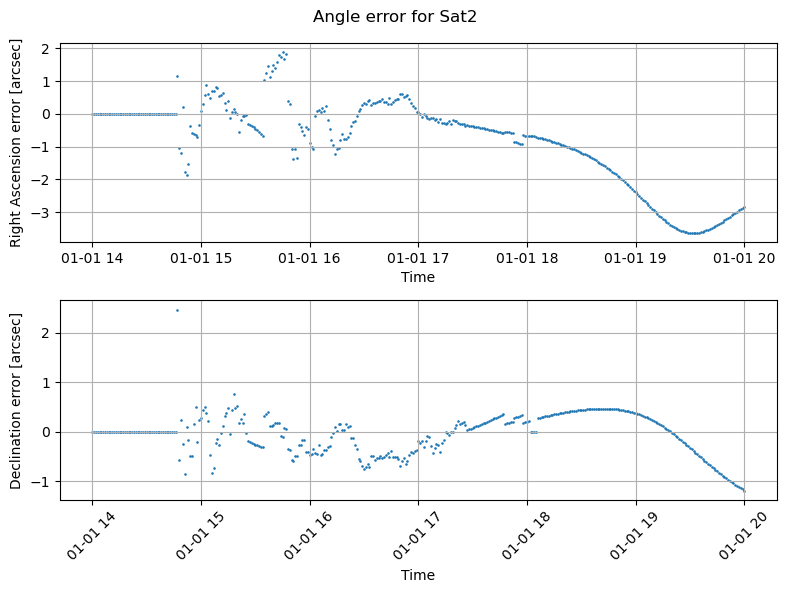

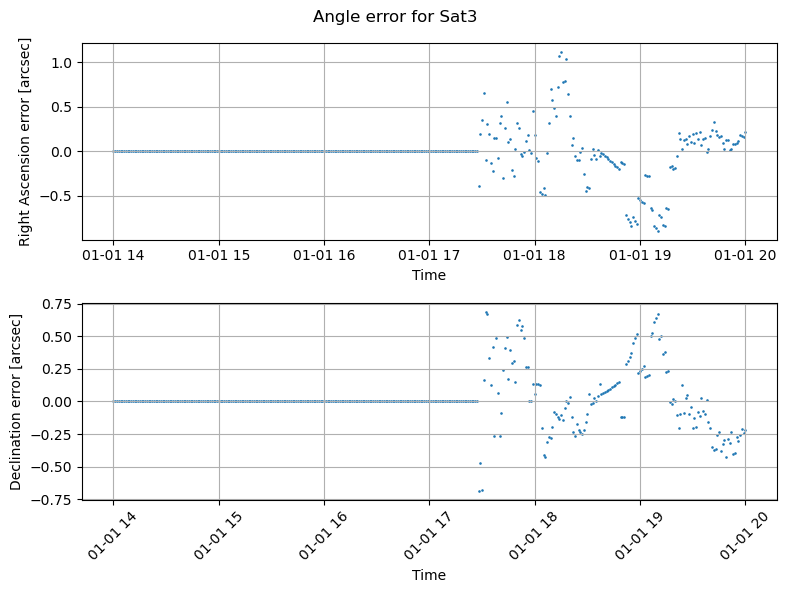

In [37]:
for target in targets:
    true_ra_array = np.array([true_ra_deg[target][i] for i in idxs]) 
    true_dec_array = np.array([true_dec_deg[target][i] for i in idxs]) 
    est_ra_array = np.array([(est_ra[target][i]) for i in idxs]) 
    est_dec_array = np.array([(est_dec[target][i]) for i in idxs])  

    ra_err = (true_ra_array - est_ra_array) * 3600
    dec_err = (true_dec_array - est_dec_array) * 3600

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 1, 1)
    plt.scatter(times_utc, (ra_err),marker='.',s=3, label="Ra error")
    plt.ylabel("Right Ascension error [arcsec]")
    plt.xlabel("Time")
    plt.grid(True)
    # plt.ylim([-20, 20])

    plt.subplot(2, 1, 2)
    plt.scatter(times_utc, (dec_err),marker='.',s=3, label="Dec error")
    plt.ylabel("Declination error [arcsec]")
    plt.xlabel("Time")
    plt.grid(True)

    plt.suptitle(f"Angle error for {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

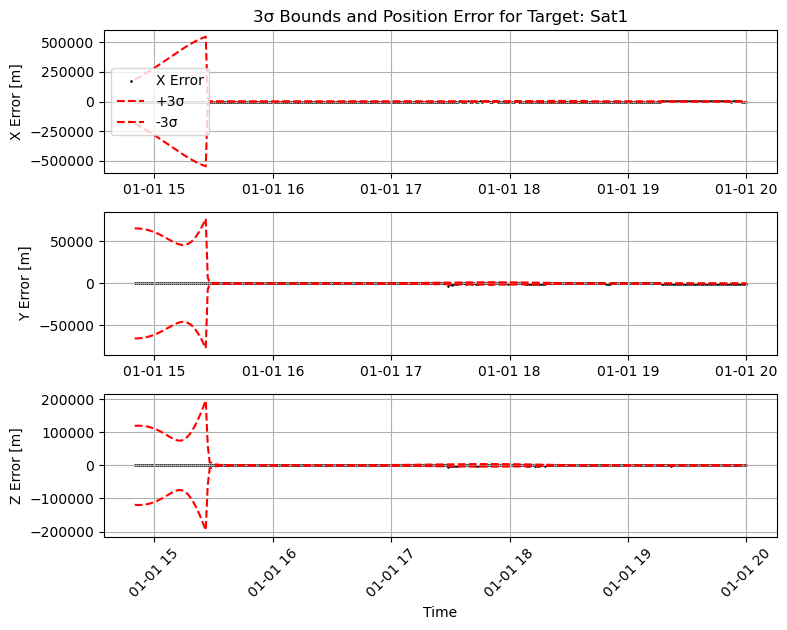

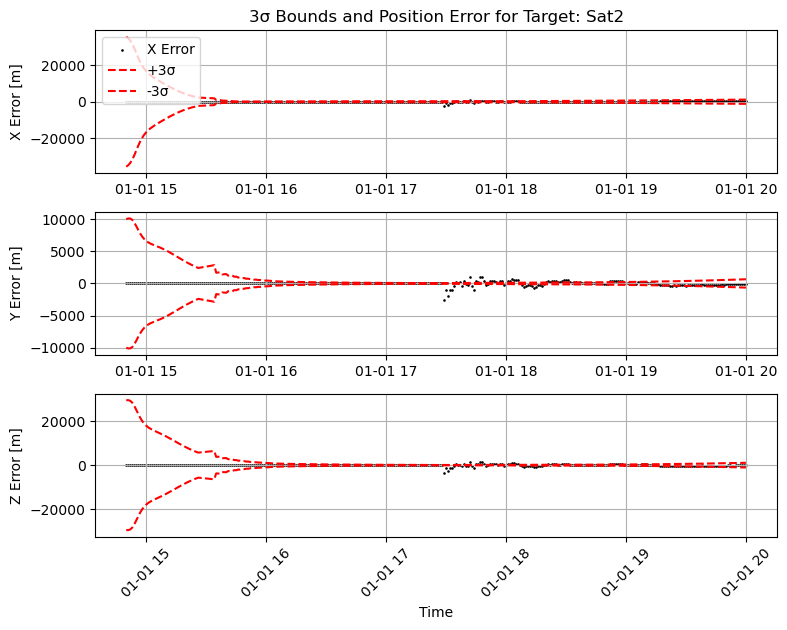

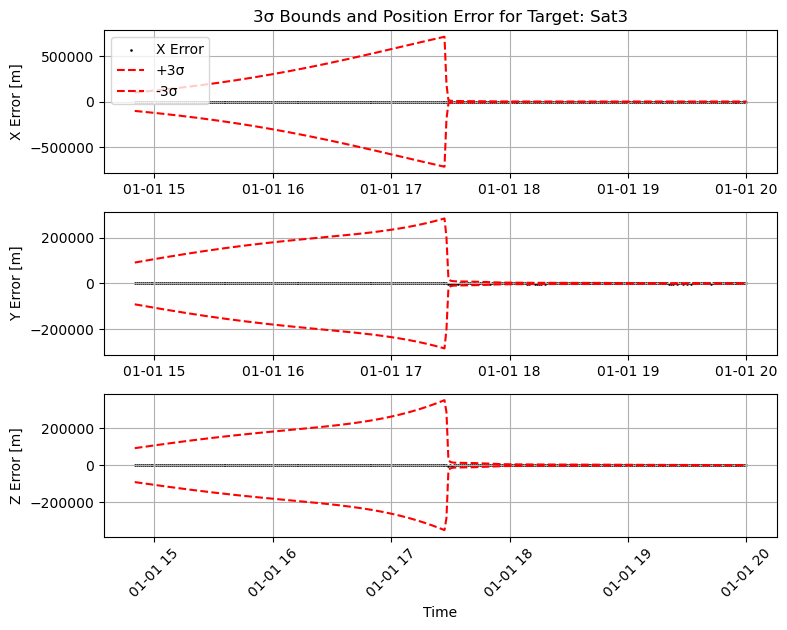

In [38]:
for target in targets:

    cov_array = np.array([est_cov[target][i] for i in idxs])              # shape (N, 6, 6)

    sigma_3 = 3 * np.sqrt(np.array([np.diag(P)[0:3] for P in cov_array])) * 1000 # shape (N, 3)

    x_3sig, y_3sig, z_3sig = sigma_3[:, 0], sigma_3[:, 1], sigma_3[:, 2]

    # Time vector (assumed pre-defined)
    t_plot = times_utc[:]  # or just `idxs` if no time vector

    # Plotting
    plt.figure(figsize=(8, 6))

    for i, (err, sig, label) in enumerate(zip([x_err, y_err, z_err],
                                            [x_3sig, y_3sig, z_3sig],
                                            ['X', 'Y', 'Z'])):
        plt.subplot(3, 1, i + 1)
        plt.scatter(t_plot[50:], err[50:],marker='.',s=3, label=f'{label} Error', color='black')
        plt.plot(t_plot[50:], sig[50:], 'r--', label='+3σ')
        plt.plot(t_plot[50:], -sig[50:], 'r--', label='-3σ')
        # plt.ylim([-1000, 1000])
        plt.ylabel(f'{label} Error [m]')
        plt.grid(True)
        if i == 2:
            plt.xlabel("Time")
        if i == 0:
            plt.title(f"3σ Bounds and Position Error for Target: {target}")
        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

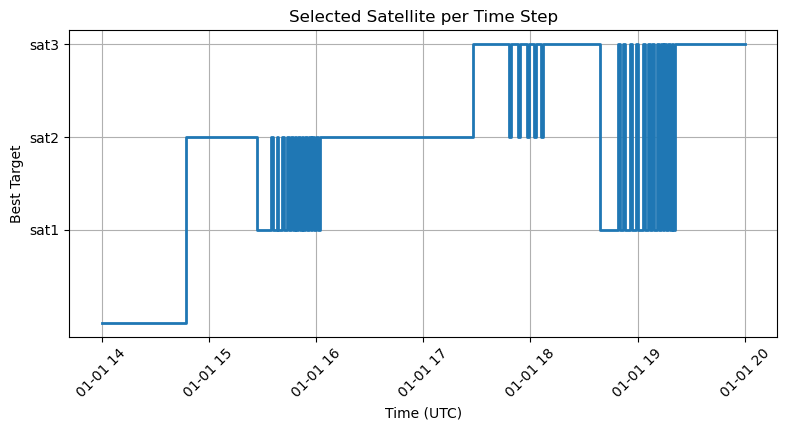

In [39]:
# Convert best_target dict to sorted list
best_sat_series = [best_target_num_log[i] for i in sorted(best_target_num_log.keys())]

plt.figure(figsize=(8, 4))
plt.step(times_utc, best_sat_series, where='post', linewidth=2)
plt.yticks([1, 2, 3], ['sat1', 'sat2', 'sat3'])
plt.xlabel("Time (UTC)")
plt.ylabel("Best Target")
plt.title("Selected Satellite per Time Step")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
